# Tutorial 2: SSALib Plotting Guide

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/02_ssa_plotting_guide.ipynb)

This tutorial covers the available visualizations in SSALib, illustrated using Sea Surface Temperature (SST) data.


**Quick link**

* [`kind='matrix'`](#Matrix-Plot)
* [`kind='paired'`](#Paired-Plot)
* [`kind='periodogram'`](#Periodogram-Plot)
* [`kind='timeseries'`](#Timeseries-Plot)
* [`kind='values'`](#Value-Plot)
* [`kind='vectors'`](#Vector-Plot)
* [`kind='wcorr'`](#Weighted-Correlation-Plot)

In [1]:
#!pip install git+https://github.com/ADSCIAN/ssalib.git # Uncomment to install ssalib

from ssalib import SingularSpectrumAnalysis as SSA
from ssalib.datasets import load_sst

#help(SingularSpectrumAnalysis.plot)  # Uncomment to get help

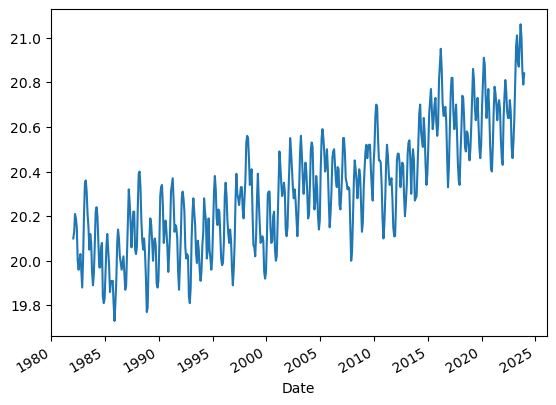

In [2]:
#help(load_sst)  # Uncomment to get help
sst = load_sst() # Sea Surface Temperature Data
_ = sst.plot()

## Overview

* The `SingularSpectrumAnalysis.plot` method can be used to access all kinds of plots.
* Some plot kinds, or some kind-specific features, depends on the SSA stage (i.e, initialized, decomposed, or reconstructed).
* All available kinds can be accessed by calling the method `SingularSpectrumAnalysis.available_plots()`

In [3]:
SSA.available_plots()

['matrix', 'paired', 'periodogram', 'timeseries', 'values', 'vectors', 'wcorr']

## Plot Kinds

### Matrix Plot

_Decomposition optional_

Matrix plot (`kind='matrix'`) enables plotting the SVD matrix being decomposed, or its reconstruction based on a selection of indices. The matrix plot is mostly meant for an educative and development purpose.

**Kind-Specific Arguments**
- `indices`: list of indices for matrix reconstruction. If None (default), the original matrix is shown.

**Extra Arguments**

- See [`matplotlib.pyplot.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

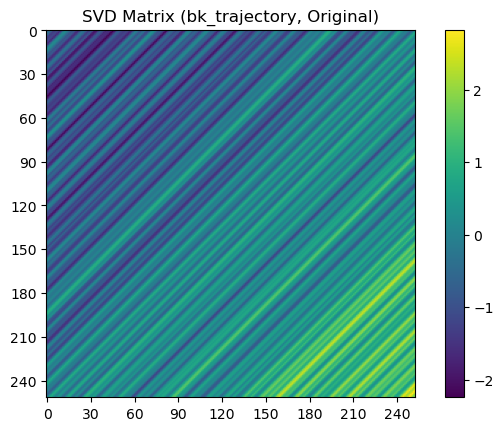

In [4]:
ssa_bk = SSA(sst) # svd_matrix_kind is 'bk_trajectory' by default
_ = ssa_bk.plot(kind='matrix')

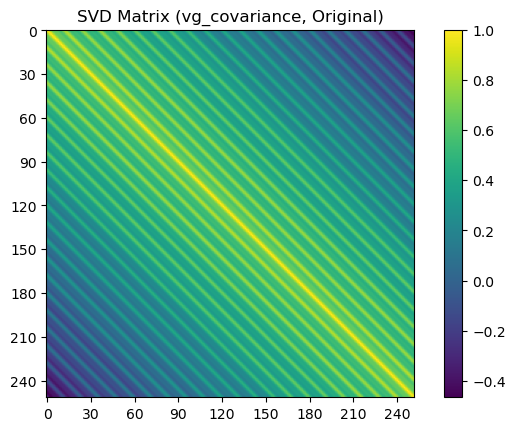

In [5]:
ssa_vg = SSA(sst, svd_matrix_kind='vg_covariance')
_ = ssa_vg.plot(kind='matrix')

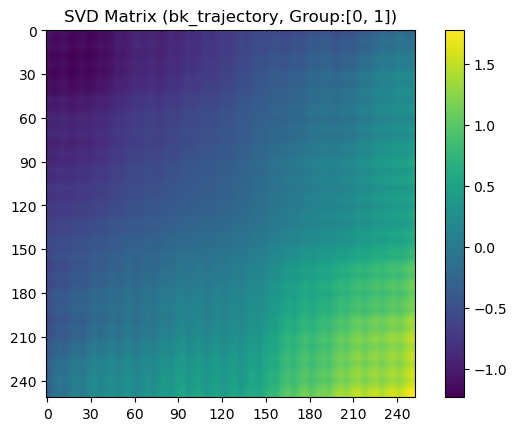

In [6]:
ssa_bk.decompose()
_ = ssa_bk.plot(kind='matrix', indices=[0,1])

### Paired Plot

_Decomposition required._

Paired plot (`kind='paired'`) is a collection of subplots illustrating patterns for successive pairs of eigenvectors. Paired plot is used for structured pattern recognition and to hint on the frequency of the reconstructed patterns. This visualization is inspired from the
rSSA package in R.

**Kind-Specific Arguments**
- n_components: the maximum number of components to include. Default is 10.

**Extra Arguments**

- See [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

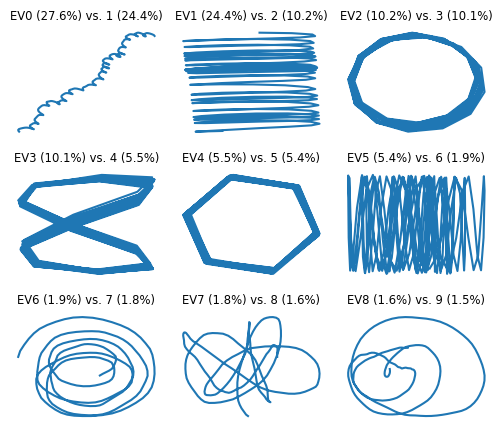

In [7]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='paired')

**Remarks**
* Pairs of eigenvectors EV0 and 1 highlight a mostly non-repetitive pattern corresponding to a trend.
* EV2 and 3 highlight a dodecagon, corresponding the annual cycle (since `sst` is monthly).
* EV4 and 6 highlight a hexagon, corresponding the semi-annual cycle.


### Periodogram Plot

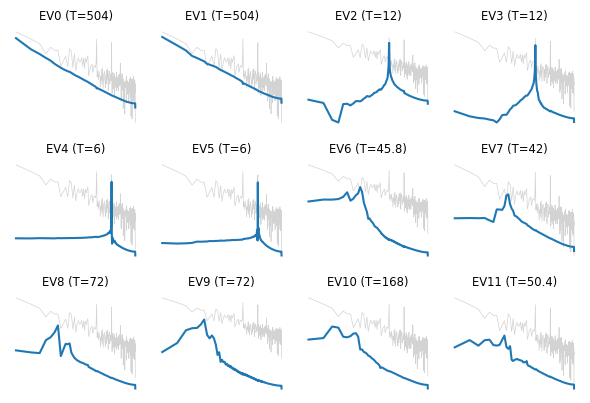

In [8]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='periodogram')

### Timeseries Plot

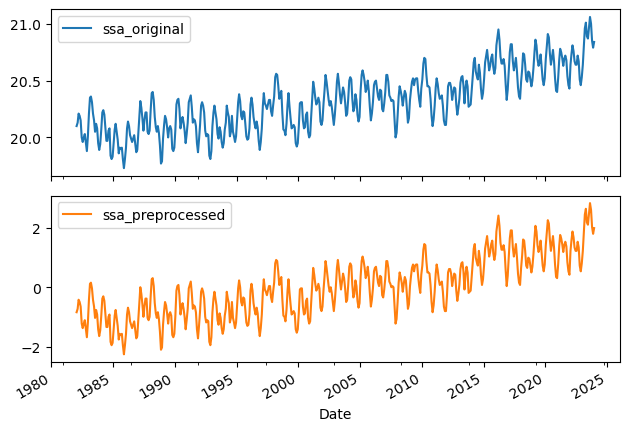

In [10]:
ssa = SSA(sst)
fig, axes = ssa.plot(kind='timeseries', subplots=True)

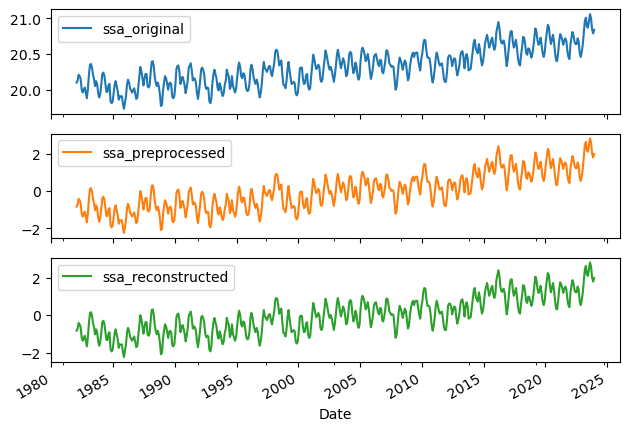

In [11]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='timeseries', subplots=True)

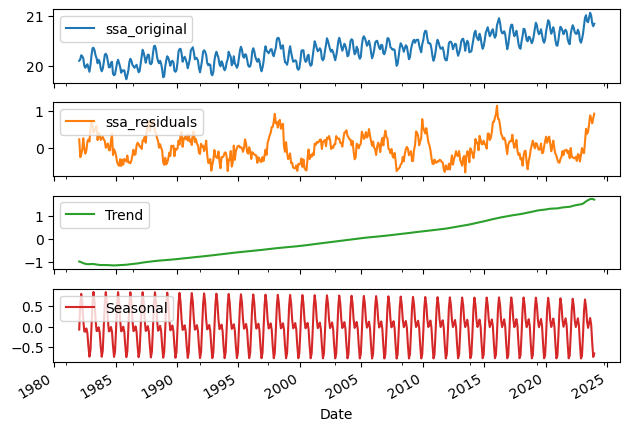

In [15]:
ssa = SSA(sst).decompose().reconstruct(groups={'Trend': [0,1], 'Seasonal': [2,3,4,5]})
fig, axes = ssa.plot(
    kind='timeseries',
    exclude=['ssa_preprocessed', 'ssa_reconstructed'],
    subplots=True
)

### Value Plot

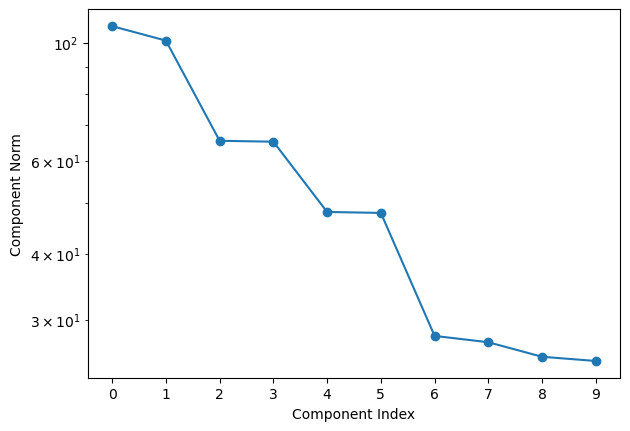

In [27]:
ssa = SSA(sst).decompose()
fig, ax = ssa.plot(marker='o')

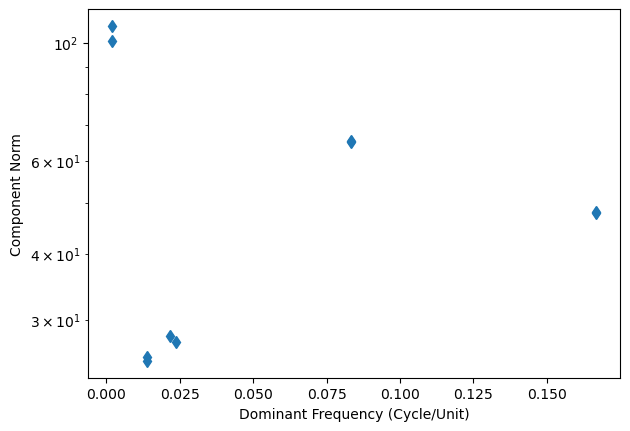

In [26]:
ssa = SSA(sst).decompose()
fig, ax = ssa.plot(rank_by='freq', marker='d', ls='none')

### Vector Plot

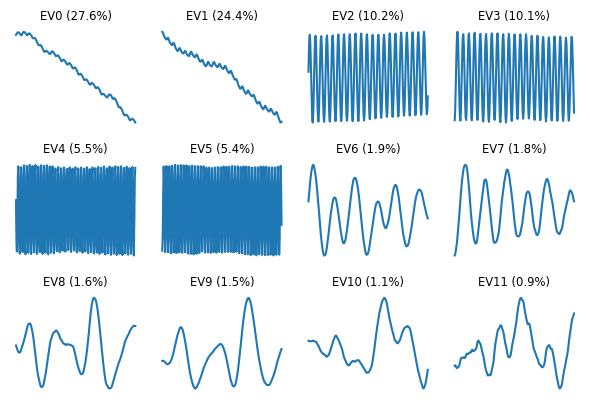

In [28]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='vectors')

## Weighted Correlation Plot

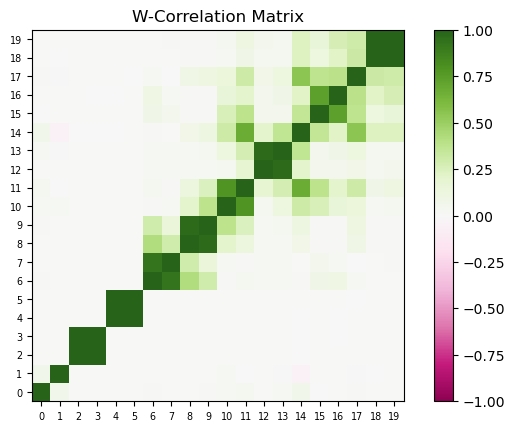

In [30]:
ssa = SSA(sst).decompose()
fig, axes = ssa.plot(kind='wcorr', n_components=20)